# Predicting Housing Prices in King County with Linear ML Models

## TODOS BEFORE SUBMISSION - EDA AND MODELING
- check on significance of date
- get dataprep to work 
- clean up - put code in python files - see Pablos comments

## Table of Contents

- [Testing Setup](#testing-setup)
    - [Create testing functions](#testing-functions)
    - [Baseline model](#baseline-model)
- [Feature Engineering and Selection](#feature-engineering)
    - [Remove outliers](#outliers)
    - [Using Zipcode vs. Clustering with Kmeans](#kmeans)
    - [Remove features](#feature-removal)
    - [Yr_built and Yr_renovated](#binning)    
    - [Testing combinations of categorical variables](#cat-combinations)
- [Grid Search](#grid-search)
- [Conclusion](#best-model)      

#### Import

In [1]:
# import tool set
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from fast_ml.model_development import train_valid_test_split

from basic_data_prep import import_data, prep_data, prep_data_long


In [2]:
# Get data from CSV
df = import_data()
df.head(3)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000


### Establish Baseline Model <a class="anchor" id="baseline-model"></a>
Here we establish baseline models and scores upon which we need to try and improve using data transformation, hyperparameter tuning, etc. The ML models chosen are those which, based on research, seemed most likely to lead to a good initial result for this problem and which were easy to implement.  
__Note:__ the baseline model is trained on all data (except for 'id' and 'date' columns) in the original state.

In [3]:
from model_evaluation import get_split, cross_val_and_eval

In [4]:
df = prep_data()
X_train, y_train, X_val, y_val, *other = get_split(df)
results = cross_val_and_eval(LinearRegression(), X_train, y_train, X_val, y_val, folds=5)

5-fold Cross Validation using only training data:
 {'mean_mae': 124577.096, 'mean_rmse': 196092.731, 'mean_rsquare': 0.704, 'mean_adj_rsquare': 0.703}
Performance on validation set:
{'mae': 123285.864, 'rmse': 198615.523, 'rsquare': 0.693, 'adj_rsquare': 0.692}


In [17]:
results

({'cross_validate_scores': {'mean_mae': 124577.096,
   'mean_rmse': 196092.731,
   'mean_rsquare': 0.704,
   'mean_adj_rsquare': 0.703}},
 {'validation set scores': {'mae': 123285.864,
   'rmse': 198615.523,
   'rsquare': 0.693,
   'adj_rsquare': 0.692}})

#### Baseline results
5-fold Cross Validation using only training data:  
- {'mean_mae': 124577.096, 'mean_rmse': 196092.731, 'mean_rsquare': 0.704, 'mean_adj_rsquare': 0.703}  

Performance on validation set:  
- {'mae': 123285.864, 'rmse': 198615.523, 'rsquare': 0.693, 'adj_rsquare': 0.692}

## Feature Engineering and Selection   <a class="anchor" id="feature-engineering"></a>
In this section we focus on experimenting with different data transformations / manipulations so that we can improve model performance. These include:
- removing outliers
- testing encoding of zipcode vs creation of geoclusters with KMeans
- removing features
- creating new features via binning
- testing different combinations of categorical / numerical variables 

### Create pipeline for transformations and testing

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [19]:
# create custom transformer class for Kmeans clustering of 'lat' and 'long'
from sklearn.base import BaseEstimator, TransformerMixin

class KMeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=100)

    def fit(self, X, y=None):
        self.kmeans.fit(X[['lat', 'long']])
        return self

    def transform(self, X):
        X = X.copy()
        X['geo_cluster'] = self.kmeans.predict(X[['lat', 'long']])
        X.drop(['lat', 'long'], axis=1, inplace=True)
        return X

In [20]:
# function for getting df with desired numerical variables
def prep_numerical():
    numerical_df = prep_data_long().drop(['zipcode', 'waterfront', 'yr_renovated', 'price'],  axis=1)
    return numerical_df


In [21]:
# function for creating and testing pipeline
def test_pipeline(df,
                  model= LinearRegression(), 
                  cat_features=['zipcode'], 
                  num_features=prep_numerical().columns.to_list(),   # should maybe not be passed as default
                  scale=True,
                  cluster=True,
                  n_clusters=250,
                  preprocess=True,
                  num_scaler=StandardScaler(),
                  test_eval=False):
    
   
    # if we use Kmeans clusters we make some adjustments to df and cat_features
    if cluster:
        if 'zipcode' in df:
            df.drop('zipcode', axis=1, inplace=True)
        if 'zipcode' in cat_features:
            cat_features.remove('zipcode')    
        if 'geo_cluster' not in cat_features:
            cat_features.append('geo_cluster')
    else:
        if 'lat' in df and 'long' in df:
            df.drop(['lat', 'long'], axis=1, inplace=True)
            
     # TRANSFORMERS      
    cat_transformer = ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features) # cat_features affected by Kmeans clusters
    transformers = [cat_transformer]
    if scale:                                                 # 'if' allows us to test the impact of scaling
        num_transformer = ('num', num_scaler, num_features)
        transformers.append(num_transformer)    
    preprocessor = ColumnTransformer(transformers= transformers, remainder='passthrough')   # 'remainder' allows columns that are not explicitly mentioned to be passed through
    
    # PIPELINE STEPS - determined by arguments passed to function
    if preprocess and cluster:
        steps=[('kmeans', KMeansTransformer(n_clusters=n_clusters)),
               ('preprocessor', preprocessor),
               ('model', model)]
    elif preprocess:
        steps = [('preprocessor', preprocessor), 
                 ('model', model)]
    else:
        steps = [('model', model)]
    
    pipeline = Pipeline(steps=steps)

    # SPLIT DATA
    train_size = 0.7
    valid_size = 0.2
    test_size = 1-train_size-valid_size
    X_train, y_train, X_val, y_val, X_test, y_test = get_split(df, train_size=train_size, 
                                                               valid_size=valid_size, test_size=test_size)
    
    # CROSS-VALIDATE (only uses training data)
    cross_val_scores = execute_cross_validate(pipeline, X_train, y_train, folds=5)

    # EVALUATE ON VALIDATION SET
    val_set_scores = eval_on_set(pipeline, X_train, y_train, X_val, y_val)  

    # EVALUATE ON TEST SET
    if test_eval==True:
        X_train_full = pd.concat([X_train, X_val])
        y_train_full = pd.concat([y_train, y_val])
        test_set_scores = eval_on_set(pipeline, X_train_full, y_train_full, X_test, y_test, set_type='test')    
        return cross_val_scores, val_set_scores, test_set_scores, pipeline
    else:
        return cross_val_scores, val_set_scores, pipeline


### Outlier removal <a class="anchor" id="outliers"></a>

In [15]:
prep_data_long().drop('zipcode', axis=1).describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
count,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04
mean,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,7.657915,1788.596842,291.725008,1970.999676,84.464787,1986.620318,12758.283512,5.402966e+05
std,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,1.173200,827.759761,442.667800,29.375234,401.821438,685.230472,27274.441950,3.673681e+05
min,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,399.000000,651.000000,7.800000e+04
25%,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,1490.000000,5100.000000,3.220000e+05
50%,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,1840.000000,7620.000000,4.500000e+05
75%,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,2360.000000,10083.000000,6.450000e+05
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,6210.000000,871200.000000,7.700000e+06


#### Observations
- for floors, waterfront, view, condition and grade, it seems that outlier removal is unnecessary as the range of values is limited
- bedrooms, bathrooms, sqft values appear to have significant outliers
- Geographic location: by plotting the coordinates of the properties on a map via Tableau, we see:
    - a number of properties lie far in the East (of -121.7 degrees longitude), away from the area in which the vast majority of the data is concentrated. Aside from a cluster of 14 properties scattered around the municipality of Skykomish, These properties are fairly spread out and few in number so that removing them should have little impact on the future predictive abilities of the model. The median value of the Skykomish cluster is below the dataset median, so that for our client there also is no reason to be particularly interested in this area.
    - approx. 115 properties are located on two islands (Vashon and Maury Island) only accessible by ferry. In this case the group of properties is small but significantly larger than the first group. Furthermore, the median value of these properties is a bit above the dataset median, so presumably of interest to our client. It seems likely that the model will in the future see properties on this island, so it could be worth keeping these properties in order to be able to make better predictions.

In [3]:
from outlier_handling import detect_outliers, remove_stat_outliers, remove_geo_outliers, remove_outliers

# get overview of number of outliers per feature
feats = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price']
for f in feats:
    detect_outliers(prep_data(), f)  

Outlier caps for bedrooms
Cap 95th percentile: 5.0  Nr of data points exceeding cap: 334
Cap 99th percentile: 6.0  Nr of data points exceeding cap: 62
Cap 3 standard deviations above mean: 6.15203232911264  Nr of data points exceeding cap: 62

Outlier caps for bathrooms
Cap 95th percentile: 3.5  Nr of data points exceeding cap: 557
Cap 99th percentile: 4.25  Nr of data points exceeding cap: 187
Cap 3 standard deviations above mean: 4.422725752402071  Nr of data points exceeding cap: 187

Outlier caps for sqft_living
Cap 95th percentile: 3760.0  Nr of data points exceeding cap: 1079
Cap 99th percentile: 4980.0  Nr of data points exceeding cap: 215
Cap 3 standard deviations above mean: 4834.576458532854  Nr of data points exceeding cap: 248

Outlier caps for sqft_lot
Cap 95th percentile: 43307.200000000026  Nr of data points exceeding cap: 1080
Cap 99th percentile: 213008.0  Nr of data points exceeding cap: 211
Cap 3 standard deviations above mean: 139334.44307664287  Nr of data points e

Nr. of samples after geo-outlier removal: 20617


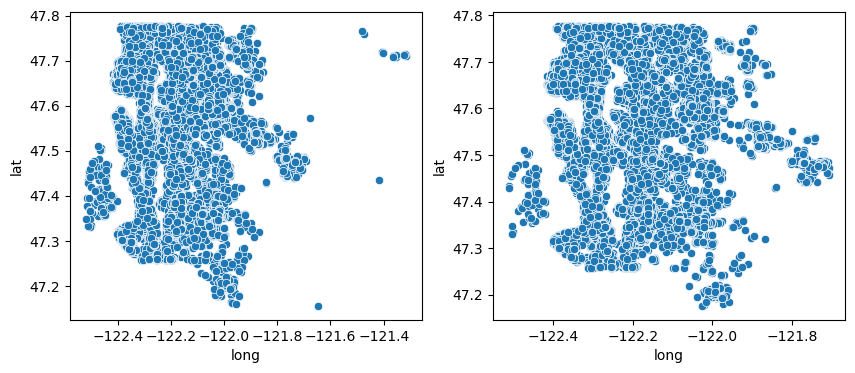

In [13]:
# test geographic outlier removal
df = prep_data()
df_sans_geo_outliers = remove_geo_outliers(df_sans_outliers)

fig, ax =plt.subplots(1,2, figsize=(10, 4))

sns.scatterplot(x=df['long'], y=df['lat'], ax=ax[0])
sns.scatterplot(x=df_sans_geo_outliers['long'], y=df_sans_geo_outliers['lat'], ax=ax[1])
fig.show()

In [6]:
# function to remove both statistical and geographical outliers
df = prep_data()
df_sans_outliers= remove_outliers(df)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617


In [34]:
# Test model performance with outlier removal but no additional processing
df_sans_outliers = remove_outliers(prep_data())
test_pipeline(df=df_sans_outliers, preprocess=False)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 107803.888, 'mean_rmse': 160393.059, 'mean_rsquare': 0.686, 'mean_adj_rsquare': 0.686}
Performance on validation set:
MAE: 113910.512, RMSE: 172034.511, R^2: 0.66, Adjusted R^2: 0.659


#### Notes:
- removing outliers has a positive impact on MAE and RMSE but negatively impacts (adjusted) r2:
    - model performance with outlier removal: {'mean_mae': 107803.888, 'mean_rmse': 160393.059, 'mean_rsquare': 0.686, 'mean_adj_rsquare': 0.686}
    - comparison to baseline: {'mean_mae': 124577.096, 'mean_rmse': 196092.731, 'mean_rsquare': 0.704, 'mean_adj_rsquare': 0.703}

### Using Zipcode vs. Kmeans Clustering of Latitude and Longitude <a class="anchor" id="kmeans"></a>

#### Zipcode

In [46]:
# Test model performance with outlier removal and encoding of zipcode
cat_features = ['zipcode']
num_features = ['bedrooms', 'bathrooms',
                'floors','view',
                'condition','grade',
                'sqft_living', 'sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']

df_sans_outliers = remove_outliers(prep_data())
test_pipeline(df=df_sans_outliers, scale=False, cluster=False, test_eval=False)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 79786.76, 'mean_rmse': 123410.56, 'mean_rsquare': 0.814, 'mean_adj_rsquare': 0.814}
Performance on validation set:
MAE: 84436.744, RMSE: 134181.479, R^2: 0.793, Adjusted R^2: 0.792


#### Notes:
- encoding zipcode in addition to removing outliers leads to significant improvement across all metrics :
    - performance with encoded zip code and outlier removal: {'mean_mae': 79786.76, 'mean_rmse': 123410.56, 'mean_rsquare': 0.814, 'mean_adj_rsquare': 0.814}
    - performance with only outlier removal: {'mean_mae': 107803.888, 'mean_rmse': 160393.059, 'mean_rsquare': 0.686, 'mean_adj_rsquare': 0.686}
    - comparison to baseline: {'mean_mae': 124577.096, 'mean_rmse': 196092.731, 'mean_rsquare': 0.704, 'mean_adj_rsquare': 0.703}

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617


<AxesSubplot:xlabel='long', ylabel='lat'>

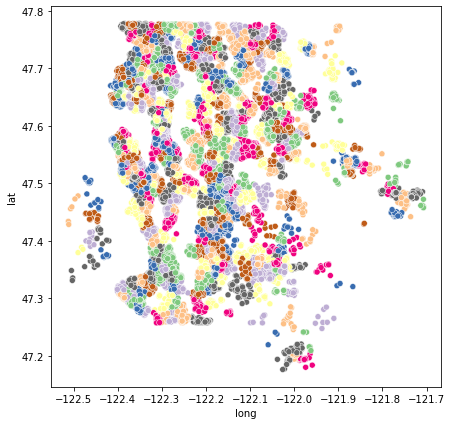

In [47]:
# function to add geo-clusters with k-means to df
def add_kmeans_clusters(df, clusters=500, drop_cols=True):
    df_geo = df.copy()
    kmeans = KMeans(clusters, random_state=100)
    clusters = kmeans.fit_predict(df_geo[['lat','long']])
    df_geo['geo_cluster'] = kmeans.predict(df_geo[['lat','long']])
    if drop_cols:
        df_geo.drop(['zipcode', 'lat', 'long'], axis=1, inplace=True)

    return df_geo

# Test creation of clusters with Kmeans
df_sans_outliers = remove_outliers(prep_data())
df_geo_clusters = add_kmeans_clusters(df_sans_outliers, clusters=500, drop_cols=False)

# Plot clusters
plt.figure(figsize = (7,7))
sns.scatterplot(df_geo_clusters['long'], df_geo_clusters['lat'], df_geo_clusters['geo_cluster'], palette='Accent', legend = False)

In [49]:
# Test performance with clustering
cat_features = ['geo_cluster']
num_features = ['bedrooms', 'bathrooms',
                'floors','view',
                'condition','grade',
                'sqft_living', 'sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']


df_sans_outliers = remove_outliers(prep_data())

# we set cluster to 'True' and provide the desired number of clusters
test_pipeline(df=df_sans_outliers, cluster= True, n_clusters = 500, scale=False, cat_features = cat_features, num_features=num_features)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 74450.64, 'mean_rmse': 115943.353, 'mean_rsquare': 0.836, 'mean_adj_rsquare': 0.836}
Performance on validation set:
MAE: 78466.053, RMSE: 127051.608, R^2: 0.814, Adjusted R^2: 0.813


#### Notes:
- creating and encoding Kmeans Clusters leads to an additional slight boost in performance in comparison to encoding zipcode :
    - performance with encoded geocluster and outlier removal: {'mean_mae': 74450.64, 'mean_rmse': 115943.353, 'mean_rsquare': 0.836, 'mean_adj_rsquare': 0.836}
    - performance with encoded zip code and outlier removal: {'mean_mae': 79786.76, 'mean_rmse': 123410.56, 'mean_rsquare': 0.814, 'mean_adj_rsquare': 0.814}
- additional testing necessary to determine the best number of clusters

In [18]:
# create function to test different numbers of clusters:

def test_number_of_clusters(models=[LinearRegression()], 
                            start_point=10, 
                            end_point = 20, 
                            increment = 5):
    
    for num in range(start_point, end_point+1, increment):

        num_features = ['bedrooms', 'bathrooms','sqft_living','sqft_lot','floors','view',
                'condition','grade',
                'sqft_above','sqft_basement','yr_built','sqft_living15','sqft_lot15']

        # in this test we encode zipcode
        cat_features = ['geo_cluster']
        
        df = remove_outliers(prep_data())
        
        
        print('Nr. of clusters: ', num)
        test_pipeline(df=df, scale=True, cluster=True, test_eval=False, 
                      cat_features= cat_features, 
                      num_features= num_features,
                      n_clusters = num)
        

In [53]:
test_number_of_clusters(models= [LinearRegression()], start_point=400, increment=20, end_point=700)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
Nr. of clusters:  400
5-fold Cross Validation using only training data:
 {'mean_mae': 74652.581, 'mean_rmse': 116341.024, 'mean_rsquare': 0.835, 'mean_adj_rsquare': 0.835}
Performance on validation set:
MAE: 79574.665, RMSE: 128187.806, R^2: 0.811, Adjusted R^2: 0.81
Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
Nr. of clusters:  420
5-fold Cross Validation using only training data:
 {'mean_mae': 74414.297, 'mean_rmse': 116281.559, 'mean_rsquare': 0.835, 'mean_adj_rsquare': 0.835}
Performance on validation set:
MAE: 79007.432, RMSE: 127068.101, R^2: 0.814, Adjusted R^2: 0.813
Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
Nr. of clusters:  440
5-fold Cross Validation using only training data:
 {'mean_mae':

#### Notes:
- Testing with a variety of cluster numbers between 50 - 700 leads to flattening performance around 450 clusters after which performance fluctuates
    - Top scores for crossvalidation are around: {'mean_mae': 74187.87, 'mean_rmse': 115639.27, 'mean_rsquare': 0.837, 'mean_adj_rsquare': 0.837} (560 clusters)
    - Top scores on validation set: MAE: 78298.058, RMSE: 126253.026, R^2: 0.817, Adjusted R^2: 0.816 (600 clusters)

### Removing features <a class="anchor" id="feature-removal"></a>
- there are several features which appear to be similar or highly correlated, including:
    - sqft_lot and sqft_lot15
    - sqft_living and sqft_living15
    - sqft_living and sqft_above
- we will therefore test the removal of these features to see whether we can simplify the model or even improve performance

In [56]:
# get an idea of feature importance
import eli5
from eli5.sklearn import PermutationImportance

def get_perm_importance(df):
    X = df.drop('price', axis=1)
    y = df['price']
    X_train, X_val, y_train, y_val = train_test_split(X, y)
    reg = LinearRegression().fit(X_train, y_train)
    perm = PermutationImportance(reg).fit(X_val, y_val)
    return eli5.show_weights(perm, feature_names= X_train.columns.tolist())

df = remove_outliers(prep_data()).drop(['lat', 'long', 'zipcode'], axis=1)
get_perm_importance(df)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617


Weight,Feature
0.3878 ± 0.0209,grade
0.2354 ± 0.0142,yr_built
0.0864 ± 0.0073,sqft_living
0.0255 ± 0.0014,sqft_living15
0.0187 ± 0.0024,view
0.0172 ± 0.0025,waterfront
0.0162 ± 0.0032,bathrooms
0.0137 ± 0.0031,bedrooms
0.0118 ± 0.0025,sqft_basement
0.0112 ± 0.0017,sqft_above


In [113]:
# test removal of features
cat_features = ['geo_cluster']
num_features = ['bedrooms', 'bathrooms',
                'floors','view',
                'condition','grade',
                'sqft_basement', 'sqft_above']


df_sans_outliers = remove_outliers(prep_data())
df_sans_outliers.drop(['sqft_living15', 'sqft_lot15', 'sqft_living'], axis=1, inplace=True)

# we set cluster to 'True' and provide the desired number of clusters
test_pipeline(df=df_sans_outliers, cluster= True, n_clusters = 500, test_eval=True, scale=False, cat_features = cat_features, num_features=num_features)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 74484.477, 'mean_rmse': 115906.314, 'mean_rsquare': 0.836, 'mean_adj_rsquare': 0.836}
Performance on validation set:
MAE: 78601.011, RMSE: 127215.895, R^2: 0.814, Adjusted R^2: 0.813
Performance on test set:
MAE: 73791.02, RMSE: 117161.583, R^2: 0.838, Adjusted R^2: 0.837


#### Notes:
- removing either ('sqft_living15', 'sqft_lot15') or ('sqft_living', 'sqft_lot') as well as either 'sqft_living or 'sqft_above' has very limited impact on model performance.

    - __Baseline:__ {'mean_mae': 74450.64, 'mean_rmse': 115943.353, 'mean_rsquare': 0.836, 'mean_adj_rsquare': 0.836}
Performance on validation set: MAE: 78466.053, RMSE: 127051.608, R^2: 0.814, Adjusted R^2: 0.813
                
    - __After removing 'sqft_living','sqft_lot':__ {'mean_mae': 74649.658, 'mean_rmse': 116098.528, 'mean_rsquare': 0.835, 'mean_adj_rsquare': 0.835} Performance on validation set: MAE: 78875.237, RMSE: 127500.718, R^2: 0.813, Adjusted R^2: 0.812

    - __After removing 'sqft_living15','sqft_lot15':__ {'mean_mae': 74506.507, 'mean_rmse': 115926.578, 'mean_rsquare': 0.836, 'mean_adj_rsquare': 0.836} Performance on validation set: MAE: 78600.731, RMSE: 127216.622, R^2: 0.814, Adjusted R^2: 0.813
    
    - __After removing 'sqft_living15','sqft_lot15', 'sqft_lot':__ {'mean_mae': 74835.725, 'mean_rmse': 116307.458, 'mean_rsquare': 0.835, 'mean_adj_rsquare': 0.835} Performance on validation set: MAE: 79047.794, RMSE: 127810.225, R^2: 0.812, Adjusted R^2: 0.811
    
    - __After removing 'sqft_living15','sqft_lot15', 'sqft_above':__ {'mean_mae': 74496.405, 'mean_rmse': 115935.649, 'mean_rsquare': 0.836, 'mean_adj_rsquare': 0.836} Performance on validation set: MAE: 78546.881, RMSE: 127212.952, R^2: 0.814, Adjusted R^2: 0.813
    
    - __After removing 'sqft_living15','sqft_lot15', 'sqft_living':__ {'mean_mae': 74484.477, 'mean_rmse': 115906.314, 'mean_rsquare': 0.836, 'mean_adj_rsquare': 0.836} Performance on validation set: MAE: 78601.011, RMSE: 127215.895, R^2: 0.814, Adjusted R^2: 0.813

- In order to simplify the model, we will remove 'sqft_living15', 'sqft_lot15' and 'sqft_above' going forward.  

In [32]:
# new prep data function to remove outliers and additional features
prep_data_ext().head(3)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,price
0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,221900
1,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,538000
2,2,1.00,770,10000,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,180000


### Year Built and Year Renovated <a class="anchor" id="binning"></a>

In [33]:
# function to convert year built to age (keeping in mind that the dataset is from 2015)
def convert_yr_built_to_age(df):
    df_age = df.copy()
    df_age['property_age'] = 2015 - df_age['yr_built']
    df_age.drop('yr_built', axis=1, inplace=True)
    return df_age


df_age = prep_data_ext().pipe(convert_yr_built_to_age)
df_age.drop(['lat', 'long'], axis=1, inplace =True)
get_perm_importance(df_age)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617


NameError: name 'get_perm_importance' is not defined

In [117]:
# test conversion of age
cat_features = ['geo_cluster']
num_features = ['bedrooms', 'bathrooms',
                'floors','view',
                'condition','grade',
                'sqft_above','sqft_basement','sqft_living','sqft_lot']

df_age = prep_data_ext().pipe(convert_yr_built_to_age)

# we set cluster to 'True' and provide the desired number of clusters
test_pipeline(df=df_age, cluster=True, n_clusters=500, scale=False, cat_features=cat_features, num_features=num_features)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 74486.849, 'mean_rmse': 115920.585, 'mean_rsquare': 0.836, 'mean_adj_rsquare': 0.836}
Performance on validation set:
MAE: 78601.928, RMSE: 127213.356, R^2: 0.814, Adjusted R^2: 0.813


In [34]:
from year_processing import bin_yr_built, bin_yr_renovated

# test binning of yr_built
cat_features = ['geo_cluster', 'yr_built_bin']
num_features = ['bedrooms', 'bathrooms',
                'floors','view',
                'condition','grade',
                'sqft_above','sqft_basement','sqft_living','sqft_lot']

df_age = prep_data_ext().pipe(bin_yr_built)
# we set cluster to 'True' and provide the desired number of clusters
results = test_pipeline(df=df_age, cluster=True, n_clusters=500, scale=False, cat_features=cat_features, num_features=num_features)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 73970.913, 'mean_rmse': 115436.483, 'mean_rsquare': 0.837, 'mean_adj_rsquare': 0.837}
Performance on validation set:
{'mae': 77864.199, 'rmse': 126537.096, 'rsquare': 0.816, 'adj_rsquare': 0.815}


Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617


<AxesSubplot:xlabel='yr_built_bin', ylabel='count'>

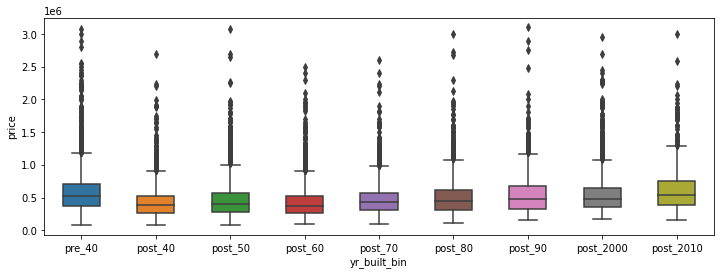

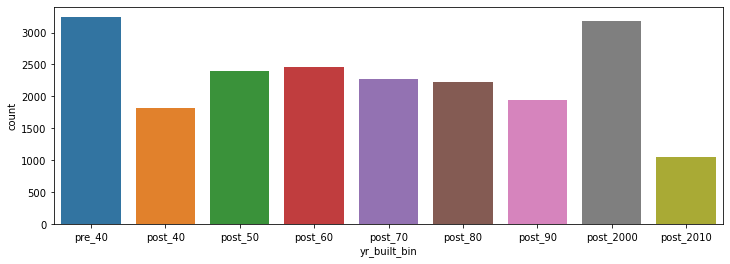

In [117]:
df_bins = prep_data_ext().pipe(bin_yr_built)
# get_boxplot(df_bins, ['yr_built_bin'])
order_of_cats = ['pre_40', 'post_40','post_50','post_60', 'post_70','post_80','post_90', 'post_2000', 'post_2010']
# order_of_cats = ['pre_10', 'post_10','post_20','post_30', 'post_40','post_50','post_60', 'post_70','post_80','post_90', 'post_2000', 'post_2010']

plt.figure(figsize=(12, 4)) 
sns.boxplot(x='yr_built_bin', y='price', data=df_bins, order=order_of_cats, width=0.5)
plt.figure(figsize=(12, 4)) 
sns.countplot(x='yr_built_bin', data=df_bins, order=order_of_cats)

 #### Notes
 - Converting yr_built to age makes practically no difference in terms of performance
 - Binning yr_built appears to have a slightly positive impact on model performance. Based on the boxplot, there could be a non-linear relationship between age and price. The reason for this could be that older properties may have historic value or a particular type of favored architecture or design.

In [44]:
# function to bin 'yr_renovated'
def bin_yr_renovated(df):
    conditions = [
#         (df['yr_renovated'] <= 1970),
#         (df['yr_renovated'] > 1970) & (df['yr_renovated'] <=2000),
#         (df['yr_renovated'] > 2000) & (df['yr_renovated'] <= 2010),
#         (df['yr_renovated'] > 2010)
        
        (df['yr_renovated'] == 0),
        (df['yr_renovated'] > 0) & (df['yr_renovated'] <=1970),
        (df['yr_renovated'] > 1970) & (df['yr_renovated'] <=1980),
        (df['yr_renovated'] > 1980) & (df['yr_renovated'] <=1990),
        (df['yr_renovated'] > 1990) & (df['yr_renovated'] <=2000),
        (df['yr_renovated'] > 2000) & (df['yr_renovated'] <= 2010),
        (df['yr_renovated'] > 2010)
        ]

    # create a list of the values we want to assign for each condition
    values = ['no renovation', 'pre_1970', 'post_70', 'post_80', 'post_90', 'post_2000','post_2010']

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['renovation_cat'] = np.select(conditions, values)
    df.drop('yr_renovated', axis = 1, inplace=True)
    
    return df

# test binning of yr_renovated and yr_built
cat_features = ['geo_cluster', 'yr_built_bin', 'renovation_cat']
num_features = ['bedrooms', 'bathrooms',
                'floors','view',
                'condition','grade',
                'sqft_above','sqft_basement','sqft_living','sqft_lot']

df_age = prep_data_ext().pipe(bin_yr_built).pipe(bin_yr_renovated)
# we set cluster to 'True' and provide the desired number of clusters
results = test_pipeline(df=df_age, cluster=True, n_clusters=500, scale=False, test_eval=False, cat_features=cat_features, num_features=num_features)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 73773.582, 'mean_rmse': 115215.965, 'mean_rsquare': 0.838, 'mean_adj_rsquare': 0.838}
Performance on validation set:
{'mae': 77647.56, 'rmse': 126157.226, 'rsquare': 0.817, 'adj_rsquare': 0.816}


#### Notes: 
- performance appears to best when binned according to decade although due to small number of renovations pre-1970 these are all binned together.
- bins: ['no renovation', 'pre_1970', 'post_70', 'post_80', 'post_90', 'post_2000','post_2010']
- performance: 
    - 5-fold Cross Validation using only training data: {'mean_mae': 73790.114, 'mean_rmse': 115286.812, 'mean_rsquare': 0.838, 'mean_adj_rsquare': 0.838}
    - Performance on validation set: {'mae': 77637.451, 'rmse': 126110.015, 'rsquare': 0.817, 'adj_rsquare': 0.816}

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617


<AxesSubplot:xlabel='renovation_cat', ylabel='price'>

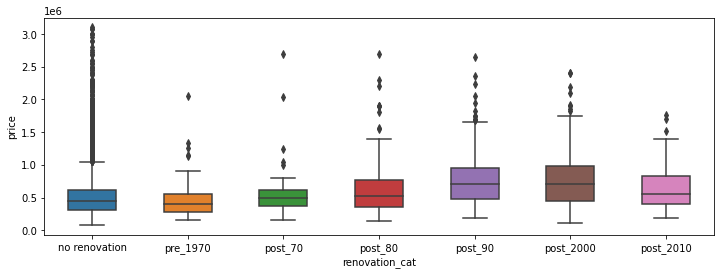

In [43]:
df_bins = prep_data_ext().pipe(bin_yr_built).pipe(bin_yr_renovated)
# get_boxplot(df_bins, ['yr_built_bin'])
order_of_cats = ['no renovation','pre_1970', 'post_70', 'post_80', 'post_90', 'post_2000','post_2010']

plt.figure(figsize=(12, 4)) 
sns.boxplot(x='renovation_cat', y='price', data=df_bins, order=order_of_cats, width=0.5)

<AxesSubplot:xlabel='renovation_cat', ylabel='count'>

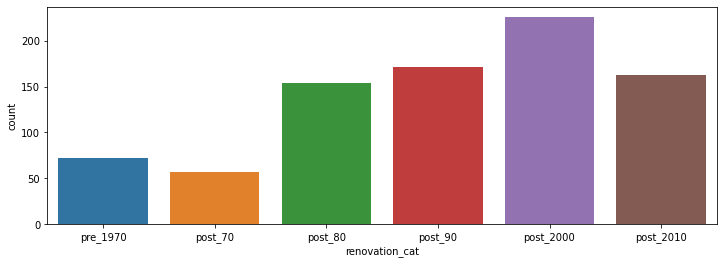

In [41]:
order_of_cats = ['pre_1970', 'post_70', 'post_80', 'post_90', 'post_2000','post_2010']
plt.figure(figsize=(12, 4)) 
sns.countplot(x='renovation_cat', data=df_bins, order=order_of_cats)

 #### Notes
 - Binning yr_renovated results in additional slight improvement of model performance. Presumably the main reason is that the '0' values (meaning 'no renovation') are now easier for the model to deal with. 

In [45]:
# function to combine yr_built and yr_renovated bins into new categorical variable
def combine_yr_built_renov(df):
    df_new = df.copy()
    df_bins = df_new.pipe(bin_yr_built).pipe(bin_yr_renovated)
    df_bins['built_renov_bin'] = 'yr built bin: '+ df_bins['yr_built_bin'] + " renovation category:" + df_bins['renovation_cat']
    df_bins.drop(['yr_built_bin', 'renovation_cat'], axis=1, inplace=True)
    return df_bins


# test binning of combined feature
cat_features = ['geo_cluster', 'built_renov_bin']
num_features = ['bedrooms', 'bathrooms',
                'floors','view',
                'condition','grade',
                'sqft_above','sqft_basement','sqft_living','sqft_lot']

df_age = prep_data_ext().pipe(combine_yr_built_renov)
# we set cluster to 'True' and provide the desired number of clusters
results = test_pipeline(df=df_age, cluster=True, n_clusters=500, scale=False, cat_features=cat_features, num_features=num_features)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 73993.895, 'mean_rmse': 115502.327, 'mean_rsquare': 0.837, 'mean_adj_rsquare': 0.837}
Performance on validation set:
{'mae': 77731.221, 'rmse': 126095.343, 'rsquare': 0.817, 'adj_rsquare': 0.816}


#### Notes:
- combining yr_built and yr_renovated bins results in very similar performance (slightly lower MAE but also slightly lower R2) as keeping them distinct

In [25]:
# adjust prep_data function to include distinct bins 
def prep_data_ext_bins():
    df = prep_data_ext().pipe(bin_yr_built).pipe(bin_yr_renovated)
    return df

prep_data_ext_bins().head()

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,zipcode,lat,long,price,yr_built_bin,renovation_cat
0,3,1.00,1180,5650,1.0,0,0,3,7,0,98178,47.5112,-122.257,221900,post_war,not relevant
1,3,2.25,2570,7242,2.0,0,0,3,7,400,98125,47.7210,-122.319,538000,post_war,distant
2,2,1.00,770,10000,1.0,0,0,3,6,0,98028,47.7379,-122.233,180000,pre_war,not relevant
3,4,3.00,1960,5000,1.0,0,0,5,7,910,98136,47.5208,-122.393,604000,post_war,not relevant
4,3,2.00,1680,8080,1.0,0,0,3,8,0,98074,47.6168,-122.045,510000,post_80,not relevant


### Test different combinations of categorical variables <a class="anchor" id="cat-combinations"></a>
- there are some features which include ordinal numbers (view, grade, condition) and therefore can be treated as either numerical or categorical features. 
- some features such as floors, bedrooms and bathrooms also only include a limited number of options and therefore can also be treated as categorical

In [64]:
# test encoding of 'grade'
cat_features = ['geo_cluster', 'yr_built_bin', 'renovation_cat', 'grade']
num_features = ['bedrooms', 'bathrooms', 'view','condition','floors',
                'sqft_above','sqft_basement','sqft_living','sqft_lot']

df =  prep_data_ext_bins()
# we set cluster to 'True' and provide the desired number of clusters
results = test_pipeline(df=df, cluster=True, n_clusters=500, scale=False, test_eval=True, cat_features=cat_features, num_features=num_features)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 71031.964, 'mean_rmse': 110798.495, 'mean_rsquare': 0.85, 'mean_adj_rsquare': 0.85}
Performance on validation set:
{'mae': 75909.78, 'rmse': 123442.877, 'rsquare': 0.825, 'adj_rsquare': 0.824}
Performance on test set:
{'mae': 70781.803, 'rmse': 112457.226, 'rsquare': 0.851, 'adj_rsquare': 0.85}


#### Notes:
- encoding 'grade' as categorical variable results in additional performance boost:
{'mean_mae': 71031.964, 'mean_rmse': 110798.495, 'mean_rsquare': 0.85, 'mean_adj_rsquare': 0.85}
Performance on validation set:
MAE: 75909.78, RMSE: 123442.877, R^2: 0.825, Adjusted R^2: 0.824
- encoding 'floors' results in worse performance

In [108]:
# get all possible combinations of categorical variables

# function for generating all possible combinations of items in a list
def get_combinations(options):
    combinations= []
    for r in range(1, len(options) + 1):  # starting at 1 rather than 0 avoids creating an 'empty' subset
        for subset in itertools.combinations(options, r):
            combinations.append(list(subset))
    return combinations

potential_cat_features = ['grade', 'bedrooms', 'bathrooms', 'view', 'condition','floors']
combinations = get_combinations(potential_cat_features)
combinations

[['grade'],
 ['bedrooms'],
 ['bathrooms'],
 ['view'],
 ['condition'],
 ['floors'],
 ['grade', 'bedrooms'],
 ['grade', 'bathrooms'],
 ['grade', 'view'],
 ['grade', 'condition'],
 ['grade', 'floors'],
 ['bedrooms', 'bathrooms'],
 ['bedrooms', 'view'],
 ['bedrooms', 'condition'],
 ['bedrooms', 'floors'],
 ['bathrooms', 'view'],
 ['bathrooms', 'condition'],
 ['bathrooms', 'floors'],
 ['view', 'condition'],
 ['view', 'floors'],
 ['condition', 'floors'],
 ['grade', 'bedrooms', 'bathrooms'],
 ['grade', 'bedrooms', 'view'],
 ['grade', 'bedrooms', 'condition'],
 ['grade', 'bedrooms', 'floors'],
 ['grade', 'bathrooms', 'view'],
 ['grade', 'bathrooms', 'condition'],
 ['grade', 'bathrooms', 'floors'],
 ['grade', 'view', 'condition'],
 ['grade', 'view', 'floors'],
 ['grade', 'condition', 'floors'],
 ['bedrooms', 'bathrooms', 'view'],
 ['bedrooms', 'bathrooms', 'condition'],
 ['bedrooms', 'bathrooms', 'floors'],
 ['bedrooms', 'view', 'condition'],
 ['bedrooms', 'view', 'floors'],
 ['bedrooms', 'cond

In [232]:
# function to add test results to dict
def add_results(data, results, cat_subset):
    data['categorical_features'].append(cat_subset)
#     data['model'].append(list(results.keys()))  # if key does not exist, append 'N/A'
    data['cv_mean_mae'].append(results[0]['cross_validate_scores'].get('mean_mae', float('nan')))  # if key does not exist, append NaN
    data['cv_mean_rmse'].append(results[0]['cross_validate_scores'].get('mean_rmse', float('nan')))  # if key does not exist, append NaN
    data['cv_mean_rsquare'].append(results[0]['cross_validate_scores'].get('mean_rsquare', float('nan')))  # if key does not exist, append NaN
    data['cv_mean_adj_rsquare'].append(results[0]['cross_validate_scores'].get('mean_adj_rsquare', float('nan')))  # if key does not exist, append NaN

    return data


# main function for testing different combinations
def test_combinations(opt_features_list, fixed_features_list, model=LinearRegression()):
    
    data = {
        'categorical_features': [],
        'cv_mean_mae': [], 
        'cv_mean_rmse': [],
        'cv_mean_rsquare': [],
        'cv_mean_adj_rsquare': [],
    }
    
    categorical_combinations = get_combinations(opt_features_list)
        
    # loop through categorical feature combinations
    for cat_subset in categorical_combinations:
        
        categorical_features = cat_subset + fixed_features_list   # we add optional features to fixed features
        print(categorical_features)
        
        results = test_pipeline(df=prep_data_ext_bins(), model=model, cluster=True, n_clusters=500, scale=False, cat_features=categorical_features)
        
        # FIT MODEL AND GET RESULTS
        data = add_results(data, results, categorical_features)
    
    data_df = pd.DataFrame.from_dict(data)
    return data_df

# we will use zipcode because this is much faster for testing purposes
fixed_cat_features = ['geo_cluster', 'yr_built_bin', 'renovation_cat']
optional_cat_features = ['grade', 'bedrooms', 'bathrooms', 'view', 'condition','floors']


# WARNING - RUNNING THE FOLLOWING LINE OF CODE ON CPU TAKES >30 MINUTES TO COMPLETE
# results_df = test_combinations(optional_cat_features, fixed_cat_features, model=LinearRegression())

['grade', 'geo_cluster', 'yr_built_bin', 'renovation_cat']
Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 71024.221, 'mean_rmse': 110811.247, 'mean_rsquare': 0.85, 'mean_adj_rsquare': 0.85}
Performance on validation set:
{'mae': 75908.222, 'rmse': 123445.834, 'rsquare': 0.825, 'adj_rsquare': 0.824}
['bedrooms', 'geo_cluster', 'yr_built_bin', 'renovation_cat']
Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 74080.186, 'mean_rmse': 115556.722, 'mean_rsquare': 0.837, 'mean_adj_rsquare': 0.837}
Performance on validation set:
{'mae': 77787.684, 'rmse': 126261.053, 'rsquare': 0.817, 'adj_rsquare': 0.816}
['bathrooms', 'geo_cluster', 'yr_built_bin', 'renovation_cat']
Nr. of samples: 21597
Nr. of samples after sta

In [236]:
# results.to_csv('geo_cluster_cat_results.csv')

In [39]:
if 'results_df' in locals():
    df = results_df
else:
    df = pd.read_csv('geo_cluster_cat_results.csv')

pd.set_option('display.max_colwidth', None)
df.sort_values('mean_mae').head(5)

,Unnamed: 0,categorical_features,mean_mae,mean_rmse,mean_rsquare,mean_adj_rsquare
57,57,"['grade', 'bedrooms', 'bathrooms', 'view', 'floors', 'geo_cluster', 'yr_built_bin', 'renovation_cat']",70674.598,110133.211,0.852,0.852
62,62,"['grade', 'bedrooms', 'bathrooms', 'view', 'condition', 'floors', 'geo_cluster', 'yr_built_bin', 'renovation_cat']",70684.991,110154.510,0.852,0.852
48,48,"['grade', 'bathrooms', 'view', 'floors', 'geo_cluster', 'yr_built_bin', 'renovation_cat']",70714.297,110244.455,0.852,0.851
41,41,"['grade', 'bedrooms', 'bathrooms', 'view', 'geo_cluster', 'yr_built_bin', 'renovation_cat']",70715.252,110240.986,0.852,0.851
56,56,"['grade', 'bedrooms', 'bathrooms', 'view', 'condition', 'geo_cluster', 'yr_built_bin', 'renovation_cat']",70716.769,110257.448,0.851,0.851


In [40]:
df.sort_values('mean_adj_rsquare', ascending=False).head(5)

,Unnamed: 0,categorical_features,mean_mae,mean_rmse,mean_rsquare,mean_adj_rsquare
62,62,"['grade', 'bedrooms', 'bathrooms', 'view', 'condition', 'floors', 'geo_cluster', 'yr_built_bin', 'renovation_cat']",70684.991,110154.510,0.852,0.852
57,57,"['grade', 'bedrooms', 'bathrooms', 'view', 'floors', 'geo_cluster', 'yr_built_bin', 'renovation_cat']",70674.598,110133.211,0.852,0.852
47,47,"['grade', 'bathrooms', 'view', 'condition', 'geo_cluster', 'yr_built_bin', 'renovation_cat']",70754.624,110336.631,0.851,0.851
27,27,"['grade', 'bathrooms', 'floors', 'geo_cluster', 'yr_built_bin', 'renovation_cat']",70836.051,110429.386,0.851,0.851
21,21,"['grade', 'bedrooms', 'bathrooms', 'geo_cluster', 'yr_built_bin', 'renovation_cat']",70818.708,110451.798,0.851,0.851


In [44]:
zip_results = pd.read_csv('zip_code_cat_results.csv')
zip_results.sort_values('mean_mae', ascending=True).head(5)

,Unnamed: 0,categorical_features,mean_mae,mean_rmse,mean_rsquare,mean_adj_rsquare
57,57,"['grade', 'bedrooms', 'bathrooms', 'view', 'floors', 'zipcode', 'yr_built_bin', 'renovation_cat']",76249.824,118125.175,0.830,0.829
62,62,"['grade', 'bedrooms', 'bathrooms', 'view', 'condition', 'floors', 'zipcode', 'yr_built_bin', 'renovation_cat']",76270.592,118094.828,0.830,0.830
48,48,"['grade', 'bathrooms', 'view', 'floors', 'zipcode', 'yr_built_bin', 'renovation_cat']",76361.232,118214.244,0.829,0.829
41,41,"['grade', 'bedrooms', 'bathrooms', 'view', 'zipcode', 'yr_built_bin', 'renovation_cat']",76376.729,118245.185,0.829,0.829
60,60,"['grade', 'bathrooms', 'view', 'condition', 'floors', 'zipcode', 'yr_built_bin', 'renovation_cat']",76378.100,118194.066,0.829,0.829


In [43]:
zip_results.sort_values('mean_adj_rsquare', ascending=False).head(5)

,Unnamed: 0,categorical_features,mean_mae,mean_rmse,mean_rsquare,mean_adj_rsquare
62,62,"['grade', 'bedrooms', 'bathrooms', 'view', 'condition', 'floors', 'zipcode', 'yr_built_bin', 'renovation_cat']",76270.592,118094.828,0.830,0.830
49,49,"['grade', 'bathrooms', 'condition', 'floors', 'zipcode', 'yr_built_bin', 'renovation_cat']",76550.073,118394.265,0.829,0.829
25,25,"['grade', 'bathrooms', 'view', 'zipcode', 'yr_built_bin', 'renovation_cat']",76473.965,118325.514,0.829,0.829
21,21,"['grade', 'bedrooms', 'bathrooms', 'zipcode', 'yr_built_bin', 'renovation_cat']",76532.114,118448.548,0.829,0.829
41,41,"['grade', 'bedrooms', 'bathrooms', 'view', 'zipcode', 'yr_built_bin', 'renovation_cat']",76376.729,118245.185,0.829,0.829


#### Notes:
- the cross-validation tests indicate that, albeit the performance difference is very small, the performance is best when all or almost all of the ordinal numbers are treated as categorical variables.  
    - Encoded Categorical Variables: [grade, bedrooms, bathrooms, view, floors, geo_cluster, yr_built_bin, renovation_cat]	
    - MAE: 70674.598, RMSE: 110133.211, R2: 0.852, Adjusted R2: 0.852

In [55]:
# test constellation on validation and test sets
cat_features = ['geo_cluster', 'yr_built_bin', 'renovation_cat', 'grade', 'bedrooms', 'bathrooms','view', 'floors']
num_features = [ 'condition', 'sqft_basement','sqft_living','sqft_lot']

df =  prep_data_ext_bins()
# we set cluster to 'True' and provide the desired number of clusters
results = test_pipeline(df=df, cluster=True, n_clusters=500, scale=False, test_eval=True, cat_features=cat_features, num_features=num_features)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 70673.82, 'mean_rmse': 110159.019, 'mean_rsquare': 0.852, 'mean_adj_rsquare': 0.852}
Performance on validation set:
{'mae': 75280.92, 'rmse': 122593.332, 'rsquare': 0.827, 'adj_rsquare': 0.826}
Performance on test set:
{'mae': 69870.965, 'rmse': 111271.326, 'rsquare': 0.854, 'adj_rsquare': 0.853}


## Grid Search to find best linear model and hyperparameters <a class="anchor" id="grid-search"></a> 

In [49]:
# Setup GridSearch

# we are encoding zipcode instead of geoclusters because it is much faster for grid search
cat_features = ['zipcode', 'yr_built_bin', 'renovation_cat', 'grade', 'bedrooms', 'bathrooms','view', 'floors']
num_features = [ 'condition', 'sqft_basement','sqft_living','sqft_lot']

# Setup transformers
cat_transformer = ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
num_transformer = ('num', MinMaxScaler(), num_features)
           
# Create a preprocessor
preprocessor = ColumnTransformer(transformers= [cat_transformer, 
                                                num_transformer], 
                                 remainder='passthrough')

# Setup pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', Lasso())])

# Gridsearch params
param_grid = [
#     {'preprocessor__num': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
#      'model': [LinearRegression()]},
    {
#     'preprocessor__num': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
#     'model': [Lasso()],
    'model__alpha': [7, 7.5, 8, 8.5, 9]
    },
#     {
#     'preprocessor__num': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
#     'model': [ElasticNet()],
#     'model__alpha': [0.01, 0.1, 1, 2, 5, 10],
#     'model__l1_ratio': [0.1, 0.5, 0.9]
#     },
]

# Set up grid search 
grid_search = GridSearchCV(pipeline, param_grid, scoring='r2', cv=5)

# Fit model
df = prep_data_ext_bins()

train_size = 0.7
valid_size = 0.2
test_size = 1-train_size-valid_size

X_train, y_train, X_val, y_val, X_test, y_test = get_split(df, train_size=train_size, valid_size=valid_size, test_size=test_size)

grid_search.fit(X_train, y_train)

# Get best model, params, score
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best params: {best_params}\nBest score: {best_score}\nBest model: {best_model}")

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
Best params: {'model__alpha': 7.5}
Best score: 0.8297592959529168
Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['zipcode', 'yr_built_bin',
                                                   'renovation_cat', 'grade',
                                                   'bedrooms', 'bathrooms',
                                                   'view', 'floors']),
                                                 ('num', MinMaxScaler(),
                                                  ['condition', 'sqft_basement',
                                                   'sqft_living',
                                 

#### Notes:
- Gridsearch results:
    - Best params: {'model': Lasso(alpha=7.5), 'preprocessor__num': MinMaxScaler()}
    - Best score: 0.829752

In [51]:
# Test Grid Search Params with Zipcode Encoding
cat_features = ['zipcode', 'yr_built_bin', 'renovation_cat', 'grade', 'bedrooms', 'bathrooms','view', 'floors']
num_features = [ 'condition', 'sqft_basement','sqft_living','sqft_lot']

df =  prep_data_ext_bins()

# we set cluster to 'True' and provide the parameters from Grid Search
results = test_pipeline(model=Lasso(alpha=7.5), df=df, cluster=False, scale=True, num_scaler= MinMaxScaler(), test_eval=True, cat_features=cat_features, num_features=num_features)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 76198.213, 'mean_rmse': 118109.392, 'mean_rsquare': 0.83, 'mean_adj_rsquare': 0.83}
Performance on validation set:
{'mae': 80674.169, 'rmse': 129915.982, 'rsquare': 0.806, 'adj_rsquare': 0.805}
Performance on test set:
{'mae': 76100.419, 'rmse': 120475.135, 'rsquare': 0.829, 'adj_rsquare': 0.828}


In [54]:
# Test Grid Search Params with Geo Clusters
cat_features = ['geo_cluster', 'yr_built_bin', 'renovation_cat', 'grade', 'bedrooms', 'bathrooms','view', 'floors']
num_features = [ 'condition', 'sqft_basement','sqft_living','sqft_lot']

df =  prep_data_ext_bins()

# we set cluster to 'True' and provide the parameters from Grid Search
results = test_pipeline(model=Lasso(alpha=7.5), df=df, cluster=True, n_clusters=500, scale=True, num_scaler= MinMaxScaler(), test_eval=True, cat_features=cat_features, num_features=num_features)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 70535.167, 'mean_rmse': 110045.96, 'mean_rsquare': 0.852, 'mean_adj_rsquare': 0.852}
Performance on validation set:
{'mae': 75231.633, 'rmse': 122775.895, 'rsquare': 0.827, 'adj_rsquare': 0.826}
Performance on test set:
{'mae': 69796.409, 'rmse': 111463.911, 'rsquare': 0.853, 'adj_rsquare': 0.852}


In [120]:
# Test categorical feature-combination with Geo Clusters and LinearRegression
cat_features = ['geo_cluster', 'yr_built_bin', 'renovation_cat', 'grade', 'bedrooms', 'bathrooms','view', 'floors']
num_features = [ 'condition', 'sqft_basement','sqft_living','sqft_lot']

df =  prep_data_ext_bins()

# we set cluster to 'True' and provide the parameters from Grid Search
results = test_pipeline(model=LinearRegression(), df=df, cluster=True, n_clusters=500, scale=True, num_scaler= MinMaxScaler(), test_eval=True, cat_features=cat_features, num_features=num_features)

Nr. of samples: 21597
Nr. of samples after statistical outlier removal: 20639
Nr. of samples after geo-outlier removal: 20617
5-fold Cross Validation using only training data:
 {'mean_mae': 70609.794, 'mean_rmse': 110086.056, 'mean_rsquare': 0.852, 'mean_adj_rsquare': 0.852}
Performance on validation set:
{'mae': 75217.855, 'rmse': 122555.544, 'rsquare': 0.827, 'adj_rsquare': 0.826}
Performance on test set:
{'mae': 69745.756, 'rmse': 111124.99, 'rsquare': 0.854, 'adj_rsquare': 0.853}


## Conclusion and Best Model <a class="anchor" id="best-model"></a>

- The best performing model on the test set:  
    - LinearRegression
    - MinMaxScaler
    - Kmeans with 500 Clusters
    - cat_features = ['geo_cluster', 'yr_built_bin', 'renovation_cat', 'grade', 'bedrooms', 'bathrooms','view', 'floors']
    - num_features = [ 'condition', 'sqft_basement','sqft_living','sqft_lot']
    - Scores:  
        - 5-fold Cross Validation using only training data: {'mean_mae': 70609.794, 'mean_rmse': 110086.056, 'mean_rsquare': 0.852, 'mean_adj_rsquare': 0.852}
        - Performance on validation set: {'mae': 75217.855, 'rmse': 122555.544, 'rsquare': 0.827, 'adj_rsquare': 0.826}
        - Performance on test set: {'mae': 69745.756, 'rmse': 111124.99, 'rsquare': 0.854, 'adj_rsquare': 0.853}
- even though using grid search a Lasso model was found that performed slightly better on the validation set, this tiny performance improvement does not make the added complexity and computational cost worthwhile.